In [1]:
import itertools
import json
import logging
import multiprocessing
import os
import pickle
import unittest
from contextlib import contextmanager
from datetime import datetime
from operator import itemgetter
from random import sample

import numpy as np
import pandas as pd
import pymatgen
from pandas.testing import assert_frame_equal, assert_series_equal
from pymatgen.analysis.structure_prediction.substitution_probability import (
    SubstitutionProbability,
)

import smact
from smact import Species
from smact.structure_prediction.database import StructureDB
from smact.structure_prediction.mutation import CationMutator
from smact.structure_prediction.prediction import StructurePredictor
from smact.structure_prediction.structure import SmactStructure
from smact.structure_prediction.utilities import parse_spec, unparse_spec

# Structure Prediction

In this notebook, we aim to do a test of the structure substitution algorithm implemented in SMACT

Before we can do predictions, we need to create our cation mutator, database and a table, and a list of hypothetical compositions

## Procedure
* Create a list of hypothetical compositions
* Create a database of structures
* Create Cation Mutator
* Predict structures

## Part 1: Compositions
These compositions have generated in a different notebook and the results have been loaded in

In [5]:
comps = pd.read_csv("Li-Garnet_Comps_sus.csv")
comps.head()

,Pretty Formula,A,B,C,D,sus_factor
0,Li3Mg3(NO6)2,Mg1+,N3+,Li1+,O1-,745.566611
1,Na3Li3(NO6)2,Na1+,N3+,Li1+,O1-,748.694226
2,Li3Mg3(CO6)2,Mg1+,C3+,Li1+,O1-,748.731405
3,Na3Li3(CO6)2,Na1+,C3+,Li1+,O1-,751.940682
4,Li3Mg3Al2O12,Mg1+,Al3+,Li1+,O1-,806.236425


## Part 2: Database


Let's follow this procedure
1. Create a SMACT database and add a table which contains the result of our query



In [4]:
DB = StructureDB("Test.db")
SP = StructurePredictor(CM, DB, "Garnets")

## Part 3: Cation Mutator

In order to set up the cation mutator, we must do the following:
1. Generate a dataframe of lambda values for all species we which to consider
2. Instantiate the CationMutator class with the lambda dataframe



In [2]:
# Create the CationMutator class

# Here we use the default lambda table
CM = CationMutator.from_json()

## Part 4: Structure Prediction

#### Prerequisites: Part 1, Part 2 & Part 3

Procedure:
1. Instantiate the StructurePredictor class with the cation mutator (part 1), database (part 2) and table (part 2)
2. Predict Structures
3. Compare predicted structures with Database

In [6]:
# Corrections
cond_df = CM.complete_cond_probs()
species = list(cond_df.columns)

comps_copy = comps[["A", "B", "C", "D"]]

df_copy_bool = comps_copy.isin(species)

In [7]:
x = comps_copy[df_copy_bool].fillna(0)
x = x[x.A != 0]
x = x[x.B != 0]
x = x[x.C != 0]
x = x[x.D != 0]
x = x.reset_index(drop=True)

# x.to_csv("./Garnet_Comps_Corrected_Pym.csv", index=False)
x.head()

,A,B,C,D
0,Fe5+,Au3+,Li1+,O2-
1,Fe5+,N3+,Li1+,O2-
2,Fe5+,C3+,Li1+,O2-
3,Fe3+,S6+,Li1+,O2-
4,Fe5+,Al3+,Li1+,O2-


In [8]:
inner_merged = pd.merge(x, comps)
inner_merged.to_csv("./Li-Garnet_Comps_Corrected_Pym.csv", index=False)
inner_merged.head()

,A,B,C,D,Pretty Formula,sus_factor
0,Fe5+,Au3+,Li1+,O2-,Li3Fe3(AuO6)2,1048.627123
1,Fe5+,N3+,Li1+,O2-,Li3Fe3(NO6)2,1057.900521
2,Fe5+,C3+,Li1+,O2-,Li3Fe3(CO6)2,1063.408167
3,Fe3+,S6+,Li1+,O2-,Li3Fe3(SO6)2,1084.708271
4,Fe5+,Al3+,Li1+,O2-,Li3Al2(FeO4)3,1086.691220


In [9]:
print(inner_merged.head())
print("")
print(
    f"We have reduced our search space from {comps.shape[0]} to {inner_merged.shape[0]}"
)

      A     B     C    D Pretty Formula   sus_factor
0  Fe5+  Au3+  Li1+  O2-  Li3Fe3(AuO6)2  1048.627123
1  Fe5+   N3+  Li1+  O2-   Li3Fe3(NO6)2  1057.900521
2  Fe5+   C3+  Li1+  O2-   Li3Fe3(CO6)2  1063.408167
3  Fe3+   S6+  Li1+  O2-   Li3Fe3(SO6)2  1084.708271
4  Fe5+  Al3+  Li1+  O2-  Li3Al2(FeO4)3  1086.691220

We have reduced our search space from 2504 to 691


In [10]:
# x=x[:100]

In [11]:
# Create a list of test species
test_specs_list = [
    [
        parse_spec(inner_merged["A"][i]),
        parse_spec(inner_merged["B"][i]),
        parse_spec(inner_merged["C"][i]),
        parse_spec(inner_merged["D"][i]),
    ]
    for i in range(inner_merged.shape[0])
]

# Set up a for loop to store
from datetime import datetime

start = datetime.now()
from operator import itemgetter

preds = []
parents_list = []
probs_list = []
for test_specs in test_specs_list:
    predictions = list(SP.predict_structs(test_specs, thresh=10e-4, include_same=False))
    predictions.sort(key=itemgetter(1), reverse=True)
    parents = [x[2].composition() for x in predictions]
    probs = [x[1] for x in predictions]
    preds.append(predictions)
    parents_list.append(parents)
    probs_list.append(probs)
print(
    f"Time taken to predict the crystal structures of our search space of {inner_merged.shape[0]} with a threshold of 0.0001 is {datetime.now()-start} "
)
# print(parents_list)
print("")
# print(probs_list)

Time taken to predict the crystal structures of our search space of 691 with a threshold of 0.0001 is 0:01:28.345660 



## Part 5: Storing the results

In [50]:
# Add predictions to dataframe
import pymatgen as mg

pred_structs = []
probs = []
parent_structs = []
parent_pretty_formula = []
for i in preds:
    if len(i) == 0:
        pred_structs.append(None)
        probs.append(None)
        parent_structs.append(None)
        parent_pretty_formula.append(None)
    else:
        pred_structs.append(i[0][0].as_poscar())
        probs.append(i[0][1])
        parent_structs.append(i[0][2].as_poscar())
        parent_pretty_formula.append(
            mg.Structure.from_str(
                i[0][2].as_poscar(), fmt="poscar"
            ).composition.reduced_formula
        )

In [57]:
# Add prediction results to dataframe
inner_merged["predicted_structure"] = pred_structs
inner_merged["probability"] = probs
inner_merged["Parent formula"] = parent_pretty_formula
inner_merged["parent_structure"] = parent_structs

inner_merged[35:40]

,A,B,C,D,Pretty Formula,sus_factor,predicted_structure,probability,Parent formula,parent_structure
35,Fe3+,Se6+,Li1+,O2-,Li3Fe3(SeO6)2,1333.993967,None,NaN,None,None
36,Mn5+,Ti3+,Li1+,O2-,Li3Ti2Mn3O12,1337.856132,Li1+ Mn5+ O2- Ti3+\n1.0\n-5.961372 5.961372 5....,0.003172,Li3Ti2(PO4)3,Li1+ O2- P5+ Ti3+\n1.0\n-5.961372 5.961372 5.9...
37,Ag3+,Se6+,Li1+,O2-,Li3Ag3(SeO6)2,1348.830401,None,NaN,None,None
38,Ti3+,Se6+,Li1+,O2-,Li3Ti3(SeO6)2,1386.761748,None,NaN,None,None
39,Mn3+,Mn6+,Li1+,O2-,Li3Mn5O12,1390.537491,None,NaN,None,None


In [59]:
# output the intermediary results into a dataframe
outdir = "./Li-SP_results"
if not os.path.exists(outdir):
    os.mkdir(outdir)
fullpath = os.path.join(outdir, "pred_results.csv")
inner_merged.to_csv(fullpath)

In [66]:
# Filter dataframe to remove blank entries from dataframe
results = inner_merged.dropna()
results = results.reset_index(drop=True)
results.head()

,A,B,C,D,Pretty Formula,sus_factor,predicted_structure,probability,Parent formula,parent_structure
0,Mn5+,Ti3+,Li1+,O2-,Li3Ti2Mn3O12,1337.856132,Li1+ Mn5+ O2- Ti3+\n1.0\n-5.961372 5.961372 5....,0.003172,Li3Ti2(PO4)3,Li1+ O2- P5+ Ti3+\n1.0\n-5.961372 5.961372 5.9...
1,Mn5+,Mn3+,Li1+,O2-,Li3Mn5O12,1390.537491,Li1+ Mn5+ Mn3+ O2-\n1.0\n-5.919846 5.919846 5....,0.003172,Li3Mn2(PO4)3,Li1+ Mn3+ O2- P5+\n1.0\n-5.919846 5.919846 5.9...
2,Mn5+,V3+,Li1+,O2-,Li3Mn3V2O12,1723.667044,Li1+ Mn5+ O2- V3+\n1.0\n-5.916063 5.916063 5.9...,0.003172,Li3V2(PO4)3,Li1+ O2- P5+ V3+\n1.0\n-5.916063 5.916063 5.91...
3,Y3+,S6+,Li1+,O2-,Li3Y3(SO6)2,1730.939983,Li1+ O2- S6+ Y3+\n1.0\n-6.215615 6.215615 6.21...,0.006341,Li3Y3(TeO6)2,Li1+ O2- Te6+ Y3+\n1.0\n-6.215615 6.215615 6.2...
4,Fe5+,Cr3+,Li1+,O2-,Li3Cr2(FeO4)3,1743.330697,Cr3+ Fe5+ Li1+ O2-\n1.0\n-6.068257 6.068257 6....,0.001940,Li3Cr2(AsO4)3,As5+ Cr3+ Li1+ O2-\n1.0\n-6.068257 6.068257 6....


In [69]:
# Check if composition exists in our local database

in_db = []
for i in results["predicted_structure"]:
    comp = SmactStructure.from_poscar(i).composition()
    if len(DB.get_structs(comp, "Garnets")) != 0:
        in_db.append("Yes")
    else:
        in_db.append("No")
results["In DB?"] = in_db

No     194
Yes     14
Name: In DB?, dtype: int64


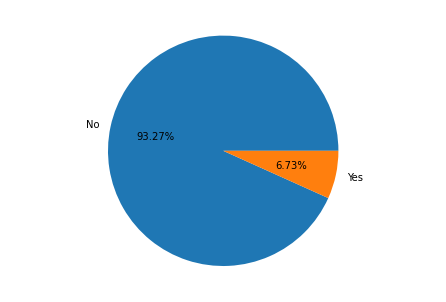

In [72]:
print(results["In DB?"].value_counts())


# Check the ratio of In DB?:Not in DB
in_db_count = results["In DB?"].value_counts()
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis("equal")
ax.pie(in_db_count, labels=["No", "Yes"], autopct="%1.2f%%")
plt.savefig(f"{outdir}/Li-Garnets_Li-In_DB_SP.png")
plt.show()

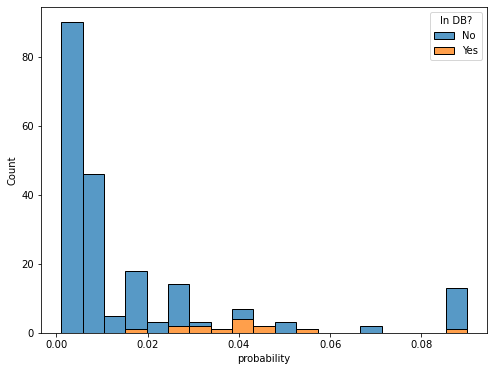

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
ax1 = sns.histplot(data=results, x="probability", hue="In DB?", multiple="stack")
# ax2=sns.histplot(new_series, label="New Garnets")
# plt.savefig("Prediction_Probability_Distribution_pym.png")

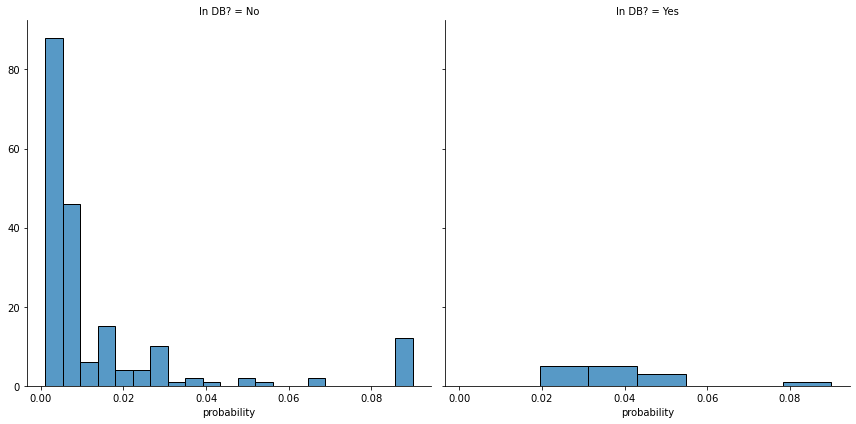

In [91]:
g = sns.FacetGrid(results, col="In DB?", height=6, aspect=1)

g.map(sns.histplot, "probability")
g.savefig("./Li-SP_results/Prob_dist.png")

In [92]:
results.head()

,A,B,C,D,Pretty Formula,sus_factor,predicted_structure,probability,Parent formula,parent_structure,In DB?
0,Mn5+,Ti3+,Li1+,O2-,Li3Ti2Mn3O12,1337.856132,Li1+ Mn5+ O2- Ti3+\n1.0\n-5.961372 5.961372 5....,0.003172,Li3Ti2(PO4)3,Li1+ O2- P5+ Ti3+\n1.0\n-5.961372 5.961372 5.9...,No
1,Mn5+,Mn3+,Li1+,O2-,Li3Mn5O12,1390.537491,Li1+ Mn5+ Mn3+ O2-\n1.0\n-5.919846 5.919846 5....,0.003172,Li3Mn2(PO4)3,Li1+ Mn3+ O2- P5+\n1.0\n-5.919846 5.919846 5.9...,No
2,Mn5+,V3+,Li1+,O2-,Li3Mn3V2O12,1723.667044,Li1+ Mn5+ O2- V3+\n1.0\n-5.916063 5.916063 5.9...,0.003172,Li3V2(PO4)3,Li1+ O2- P5+ V3+\n1.0\n-5.916063 5.916063 5.91...,No
3,Y3+,S6+,Li1+,O2-,Li3Y3(SO6)2,1730.939983,Li1+ O2- S6+ Y3+\n1.0\n-6.215615 6.215615 6.21...,0.006341,Li3Y3(TeO6)2,Li1+ O2- Te6+ Y3+\n1.0\n-6.215615 6.215615 6.2...,No
4,Fe5+,Cr3+,Li1+,O2-,Li3Cr2(FeO4)3,1743.330697,Cr3+ Fe5+ Li1+ O2-\n1.0\n-6.068257 6.068257 6....,0.001940,Li3Cr2(AsO4)3,As5+ Cr3+ Li1+ O2-\n1.0\n-6.068257 6.068257 6....,No


In [ ]:
# new_structures=

In [74]:
# pym_Li_DB=StructureDB("pym_Li.DB")
# pym_Li_DB.add_table("New")
# pym_Li_DB.add_table("not_new")
# pym_Li_DB.add_structs(new_structures,"New")
# pym_Li_DB.add_structs(exist_structures,"not_new")

In [77]:
# pym_Li_DB.add_table("not_new")

In [79]:
# pym_Li_DB.add_structs(new_structures,"New")
# pym_Li_DB.add_structs(exist_structures,"not_new")

14

In [94]:
# Periodic table BS
# Get element names
from pymatgen.util.plotting import periodic_table_heatmap

A_els = pd.Series([parse_spec(i)[0] for i in results["A"]])
B_els = pd.Series([parse_spec(i)[0] for i in results["B"]])
C_els = pd.Series([parse_spec(i)[0] for i in results["C"]])

# get dict of counts
A_els_counts = A_els.value_counts().to_dict()
B_els_counts = B_els.value_counts().to_dict()
C_els_counts = C_els.value_counts().to_dict()

/rds/general/user/aoo216/home/anaconda3/envs/exploration/lib/python3.9/site-packages/pymatgen/util/plotting.py:236: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  cbar.cmap.set_under(blank_color)


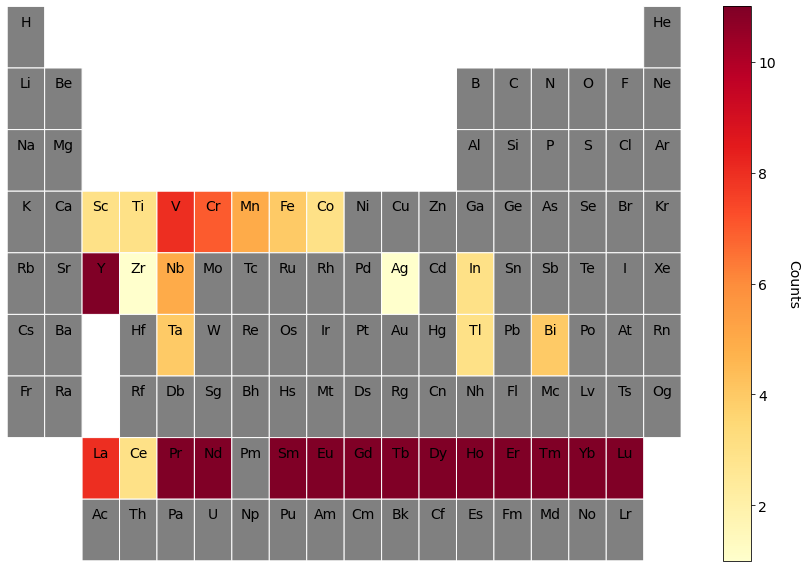

In [95]:
ax1 = periodic_table_heatmap(elemental_data=A_els_counts, cbar_label="Counts")
ax1.savefig(f"{outdir}/periodic_table_A.png")

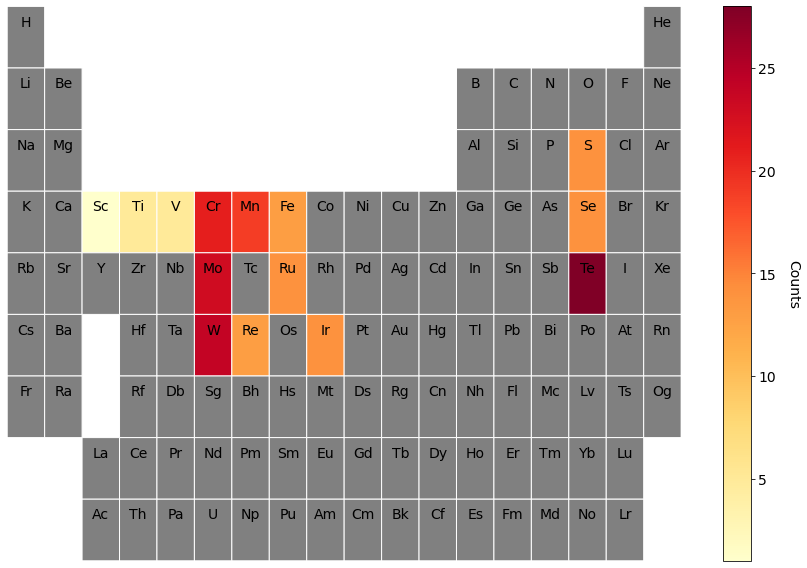

In [96]:
ax2 = periodic_table_heatmap(elemental_data=B_els_counts, cbar_label="Counts")
ax2.savefig(f"{outdir}/periodic_table_B.png")

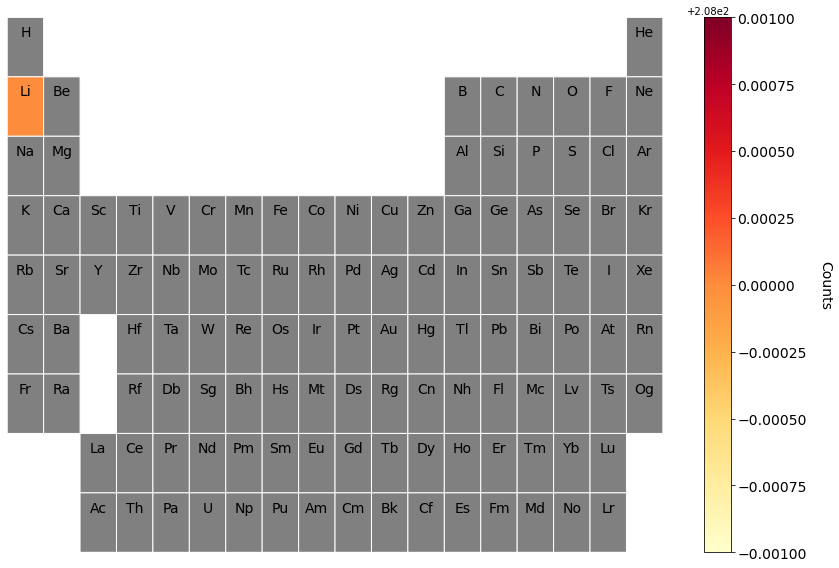

In [97]:
ax3 = periodic_table_heatmap(elemental_data=C_els_counts, cbar_label="Counts")
ax3.savefig(f"{outdir}/periodic_table_C.png")